In [39]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import IPython.display as ipd  # To play sound in the notebook
from sklearn.model_selection import StratifiedKFold
import librosa
import scipy
from scipy.io import wavfile
import wave
import tensorflow as tf
from tensorflow.keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate, Lambda)
from keras.utils import Sequence, to_categorical

In [2]:
os.listdir('data/')

['sample_submission.csv',
 'test',
 'train_curated',
 'train_curated.csv',
 'train_noisy',
 'train_noisy.csv']

In [3]:
train = pd.read_csv("data/train_curated.csv")
test = pd.read_csv("data/sample_submission.csv")

In [4]:
train.sample(5)

fname                                             labels
359   1353b699.wav                                Trickle_and_dribble
2100  6c0e4726.wav                                  Cheering,Clapping
1240  409ba0bc.wav  Cutlery_and_silverware,Dishes_and_pots_and_pan...
2558  841f0dfc.wav                                Slam,Microwave_oven
2635  87febe0b.wav                            Chewing_and_mastication

In [5]:
test.sample(5)

fname  Accelerating_and_revving_and_vroom  Accordion  \
1641  9e8aa74b.wav                                   0          0   
2131  ba826b6b.wav                                   0          0   
2912  e6b43528.wav                                   0          0   
1745  a481e842.wav                                   0          0   
3308  fcceded4.wav                                   0          0   

      Acoustic_guitar  Applause  Bark  Bass_drum  Bass_guitar  \
1641                0         0     0          0            0   
2131                0         0     0          0            0   
2912                0         0     0          0            0   
1745                0         0     0          0            0   
3308                0         0     0          0            0   

      Bathtub_(filling_or_washing)  Bicycle_bell  ...  Toilet_flush  \
1641                             0             0  ...             0   
2131                             0             0  ...             0   
2912                             0             0  ...             0   
1745                             0             0  ...             0   
3308                             0             0  ...             0   

      Traffic_noise_and_roadway_noise  Trickle_and_dribble  \
1641                                0                    0   
2131                                0                    0   
2912                                0                    0   
1745                                0                    0   
3308                                0                    0   

      Walk_and_footsteps  Water_tap_and_faucet  Waves_and_surf  Whispering  \
1641                   0                     0               0           0   
2131                   0                     0               0           0   
2912                   0                     0               0           0   
1745                   0                     0               0           0   
3308                   0                     0               0           0   

      Writing  Yell  Zipper_(clothing)  
1641        0     0                  0  
2131        0     0                  0  
2912        0     0                  0  
1745        0     0                  0  
3308        0     0                  0  

[5 rows x 81 columns]

In [6]:
train.shape, test.shape

((4970, 2), (3361, 81))

In [7]:
len(train['labels'].unique())

213

In [8]:
len(set([l for labels in train['labels'].str.split(',') for l in labels]))

80

In [9]:
len(test[1:].columns)

81

In [10]:
train = train[train.labels.isin(test.columns[1:])]
print(len(train))

4269


In [11]:
category_group = train.groupby(['labels']).count()
category_group.columns = ['counts']
category_group = category_group.sort_values(ascending=False, by='counts')
print(len(category_group))

74


<Axes: xlabel='counts', ylabel='labels'>

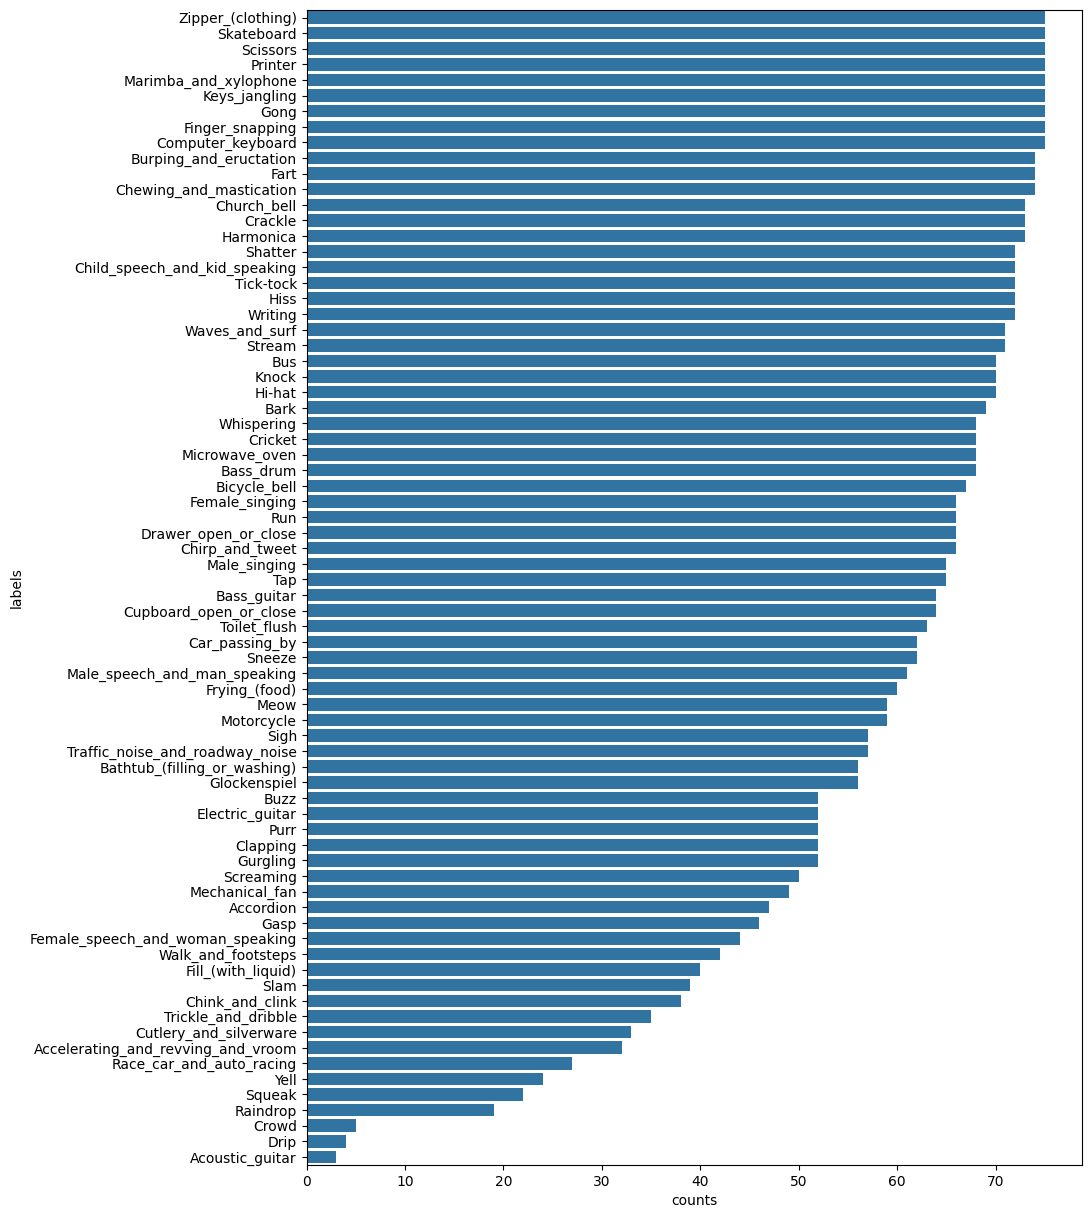

In [12]:
plt.figure(figsize=(10, 15))
sns.barplot(y=category_group.index, x=category_group.counts, orient='h')

In [13]:
fname = 'data/train_curated/0019ef41.wav'   # Raindrop
ipd.Audio(fname)

In [14]:
rate, data = wavfile.read(fname)

In [15]:
rate

44100

In [16]:
data.shape

(90616,)

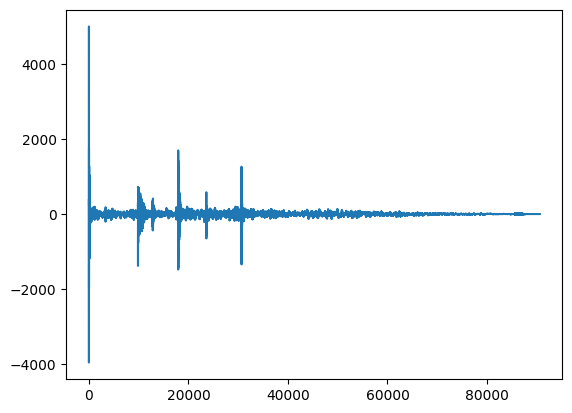

In [17]:
plt.plot(data, '-', )

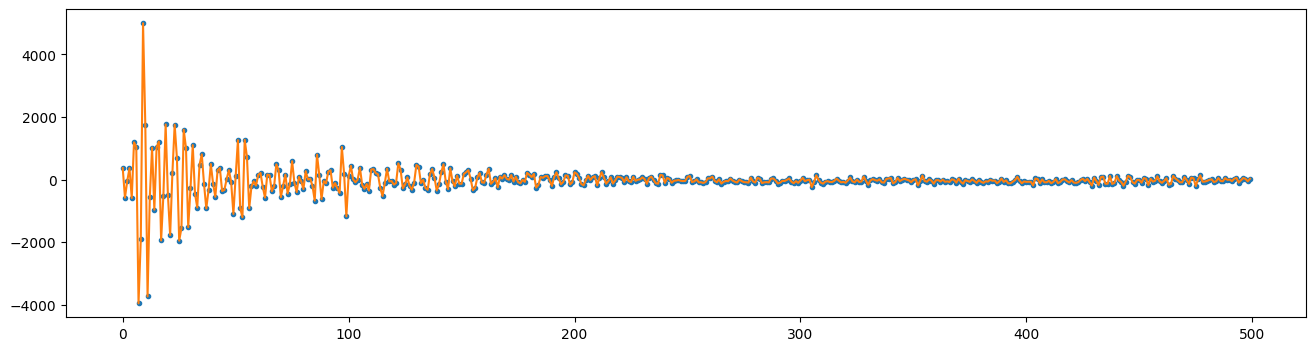

In [18]:
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

Parece haber algo raro en el nframes de Scipy, siempre da lo mismo, 44100

In [26]:
rate = wave.open(fname).getnframes()
rate

90616

In [27]:
train['nframes'] = train['fname'].apply(lambda f: wave.open('data/train_curated/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('data/test/' + f).getnframes())

In [28]:
train.sample(20)

fname                  labels  nframes
3605  ba5b5d2c.wav                    Hiss   377063
3558  b8033e51.wav               Harmonica   115461
3017  9ce8004e.wav            Male_singing    76220
4100  d45d01b7.wav                    Bark    48682
2354  79f5edd4.wav                 Crackle    45432
4428  e4dfcd9d.wav         Finger_snapping   477184
1975  65bc2fe0.wav          Microwave_oven    14558
2297  771f6c75.wav          Female_singing   627200
1878  611e2466.wav                  Squeak   171525
3361  adff8113.wav               Screaming    26752
4563  ec065344.wav              Whispering   600438
596   204908cf.wav                 Writing  1152704
4564  ec1444e0.wav                 Printer   183205
727   26863e33.wav                  Sneeze    79337
3263  a8fb9bae.wav                     Tap    67928
3866  c6230083.wav          Female_singing   107766
2878  954b16c7.wav         Electric_guitar    78538
4204  d9c600a6.wav                    Yell   129737
4460  e6b5c733.wav  Cupboard_open_or_close   146240
75    0468b055.wav          Car_passing_by  1319860

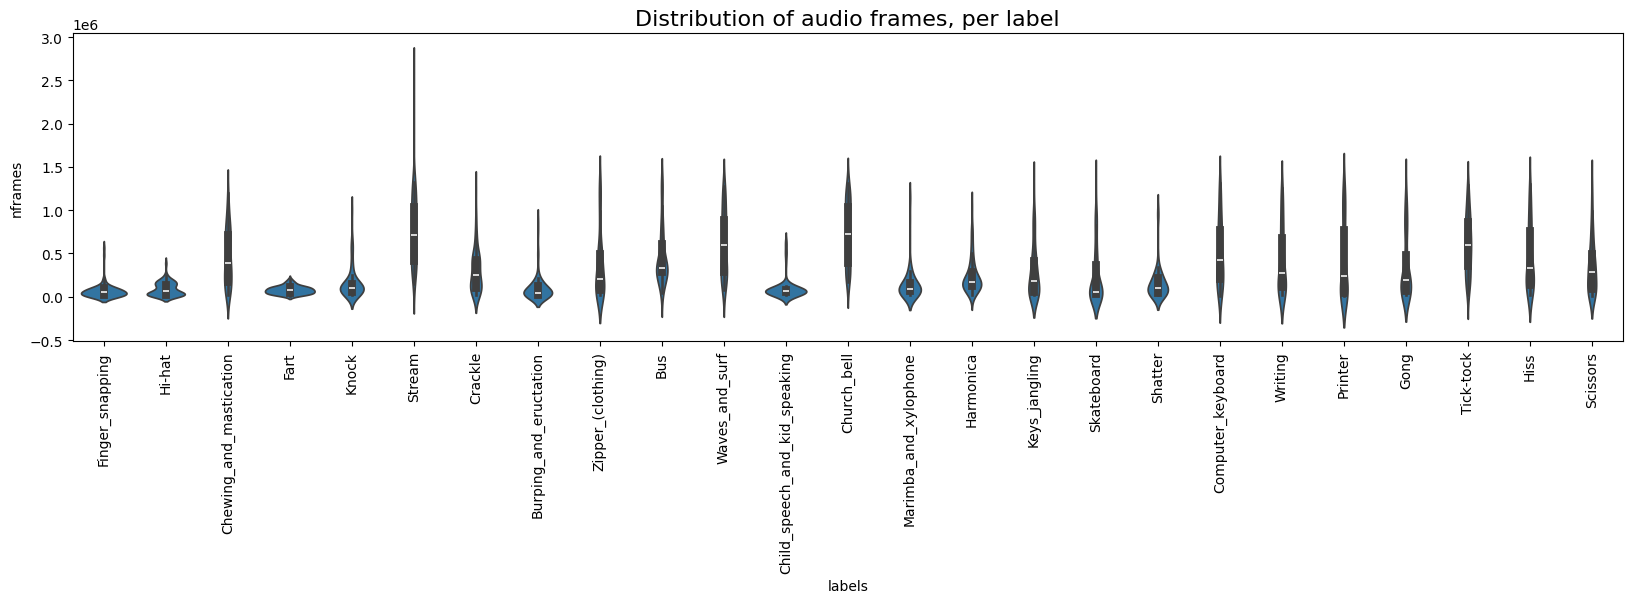

In [29]:
idx_sel = category_group.sort_values(ascending=True, by='counts').index[-25:]
_, ax = plt.subplots(figsize=(20, 4))
sns.violinplot(ax=ax, x="labels", y="nframes", data=train[(train.labels.isin(idx_sel).values)])
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

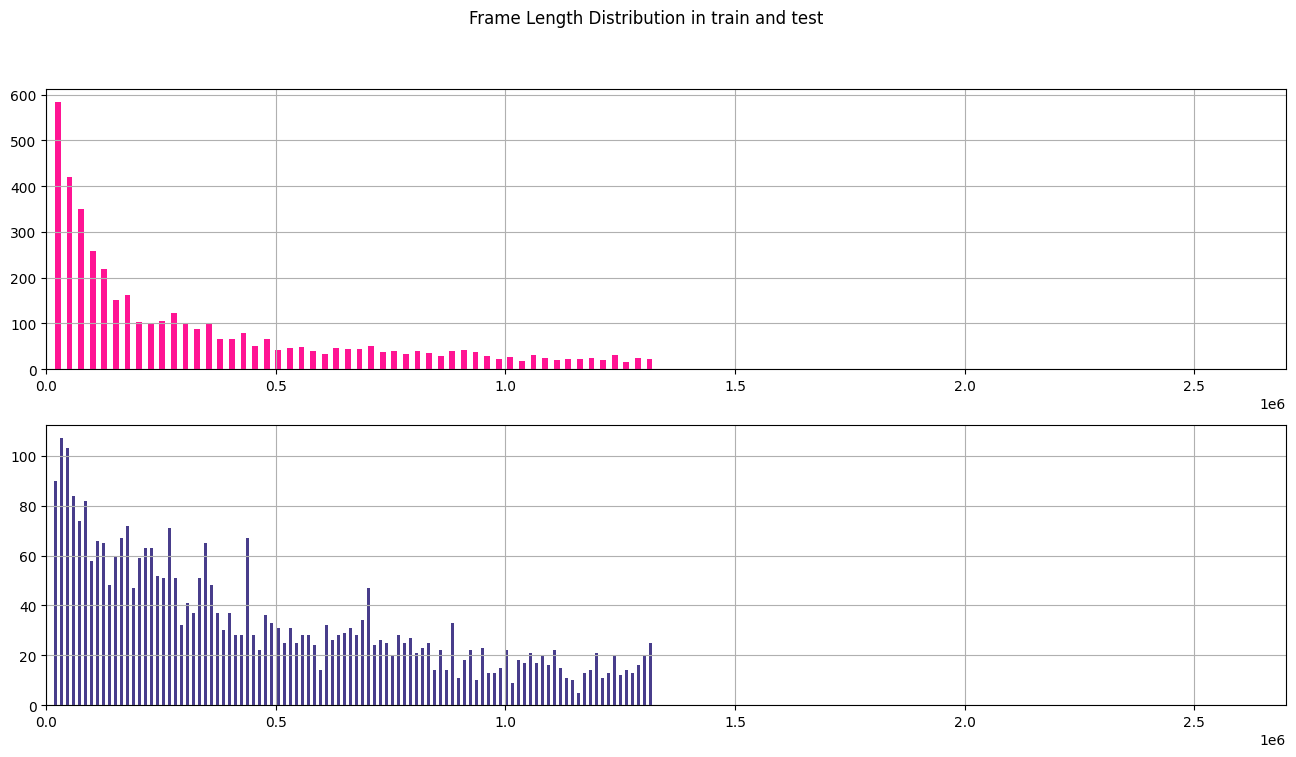

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))
train.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[0], color='deeppink')
test.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[1], color='darkslateblue')
ax[0].set_xlim(0, 2700000)
ax[1].set_xlim(0, 2700000)
plt.suptitle('Frame Length Distribution in train and test', ha='center', fontsize='large');

In [31]:
train.query("nframes > 2500000")

fname  labels  nframes
2316  77b925c2.wav  Stream  2538889

In [37]:
abnormal_length = 2538889

abnormal_fnames = train.loc[train.nframes == abnormal_length, 'fname'].values[0]
ipd.Audio( 'data/train_curated/' + abnormal_fnames)

In [48]:
AUDIO_DURATION = 2
SAMPLING_RATE = 16000
AUDIO_LENGTH = SAMPLING_RATE * AUDIO_DURATION
NUMBER_CLASS = len(train['labels'].unique())

In [40]:
class DataGenerator(Sequence):
    def __init__(self, sampling_rate, audio_length, n_classes, data_dir, list_IDs, labels=None, batch_size=64, preprocessing_fn=lambda x: x):
        self.sampling_rate  = sampling_rate 
        self.audio_length = audio_length
        self.n_classes = n_classes
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = (self.audio_length, 1)

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.sampling_rate, res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.n_classes)
        else:
            return X

In [41]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data - 0.5

In [51]:
def get_1d_conv_model():
    inp = Input(shape=(AUDIO_LENGTH,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    # x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    # x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    # x = MaxPool1D(4)(x)
    # x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(1028, activation=relu)(x)
    out = Dense(NUMBER_CLASS, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [45]:
LABELS = list(train.labels.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.labels.apply(lambda x: label_idx[x])

In [49]:
N_FOLDS = 5
MAX_EPOCHS = 50

In [52]:
skf = StratifiedKFold(n_splits=N_FOLDS)

for i, (train_split, val_split) in enumerate(skf.split(train.index, train.label_idx)):
    train_set = train.iloc[train_split]
    val_set = train.iloc[val_split]
    #checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    #tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

    callbacks_list = [early]
    print("\nFold: ", i)

    conv1d_model = get_1d_conv_model()

    train_generator = DataGenerator(SAMPLING_RATE, AUDIO_LENGTH, len(category_group), 'data/train_curated/', train_set.index, 
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm)
    val_generator = DataGenerator(SAMPLING_RATE, AUDIO_LENGTH, len(category_group), 'data/train_curated/', val_set.index, 
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm)
    
    history = conv1d_model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=MAX_EPOCHS, use_multiprocessing=True, max_queue_size=20)
    
    # model.load_weights('../working/best_%d.h5'%i)
    
    # Save train predictions
    # train_generator = DataGenerator(SAMPLING_RATE, AUDIO_LENGTH, len(category_group), 'data/train_curated/', train.index, batch_size=128,
    #                                 preprocessing_fn=audio_norm)
    # predictions = conv1d_model.predict_generator(train_generator, use_multiprocessing=True, 
    #                                       max_queue_size=20, verbose=1)
    # np.save("data/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    test_generator = DataGenerator(SAMPLING_RATE, AUDIO_LENGTH, len(category_group), '../input/test/', test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = conv1d_model.predict_generator(test_generator, use_multiprocessing=True, 
                                          max_queue_size=20, verbose=1)
    np.save("data/test_predictions_%d.npy"%i, predictions)
    
    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv("data/predictions_%d.csv"%i)



Fold:  0


c:\temp\audio_tagging\venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


AttributeError: 'Functional' object has no attribute 'fit_generator'

In [ ]:
pred_list = []
for i in range(N_FOLDS):
    pred_list.append(np.load("data/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('data/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("data/submission.csv", index=False)